#**Mini Project 2: Local Mental Health Programs**

# RPAD 676: Data Science for the Public Good

## Author: Leanna Zilles
## Date: 5/14/25

## Clean Data and Print Columns

In this section, I began my project by loading the dataset and printing its first four rows. I also cleaned and prepared the dataset so that I could later plot program locations on a map, integrating program counts into counties, and identifying how many programs exist within a given boundary.

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv('/content/Local_Mental_Health_Programs_20250414.csv')

# Display the first few rows
print(df.head())

  Row Created Date Time                            Sponsor Name  \
0       1/31/2025 10:21                            Equinox Inc.   
1       1/31/2025 10:21        Bowery Residents' Committee Inc.   
2       1/31/2025 10:21       Services for the Underserved Inc.   
3       1/31/2025 10:21                          Urban Pathways   
4       1/31/2025 10:21  Cayuga County Community Services Board   

    Sponsor Code                             Agency Name   Agency Code  \
0         280099                            Equinox Inc.         14510   
1          56099        Bowery Residents' Committee Inc.         50490   
2         419099       Services for the Underserved Inc.         22360   
3         534099                          Urban Pathways         19690   
4          80099  Cayuga County Community Services Board         70350   

                            Facility Name   Facility Code  \
0                            Equinox Inc.            7524   
1        Bowery Residents' Com

In [ ]:
import geopandas as gpd
from shapely import wkt

# Clean column names
df.columns = df.columns.str.strip()

# Drop rows with missing Georeference
df = df[df['Georeference'].notna()]

# Convert WKT string to shapely Point objects
df['geometry'] = df['Georeference'].apply(wkt.loads)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the CRS to WGS84 (lat/lon)
gdf.set_crs(epsg=4326, inplace=True)

# Preview
gdf.head()

<ipython-input-67-1f52491b974f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df['Georeference'].apply(wkt.loads)


,Row Created Date Time,Sponsor Name,Sponsor Code,Agency Name,Agency Code,Facility Name,Facility Code,Program Name,Program Code,Populations Served,...,Operating Certificate Required?,Program Tier,Operating Certificate Duration,Program County,Program Region,Program Type Description,Program Category Description,Program Subcategory Description,Georeference,geometry
0,1/31/2025 10:21,Equinox Inc.,280099,Equinox Inc.,14510,Equinox Inc.,7524,Cohoes Community Residence,430,Adults,...,Y,NaN,36.0,Albany,Hudson River,Congregate/Treatment,Residential,Treatment Program,POINT (-73.75522 42.65155),POINT (-73.75522 42.65155)
1,1/31/2025 10:21,Bowery Residents' Committee Inc.,56099,Bowery Residents' Committee Inc.,50490,Bowery Residents' Committee Inc.,6005,BRC Supported Housing/RCE New York SH - Comm Svcs,643,Adults,...,N,NaN,NaN,Bronx,New York City,Supportive Housing,Residential,Unlicensed Housing,POINT (-73.75522 42.65155),POINT (-73.75522 42.65155)
2,1/31/2025 10:21,Services for the Underserved Inc.,419099,Services for the Underserved Inc.,22360,Services for the Underserved Inc.,7320,Home Street ESSHI,31,Adults,...,N,NaN,NaN,Bronx,New York City,Supportive Single Room Occupancy (SP-SRO),Residential,Unlicensed Housing,POINT (-73.75522 42.65155),POINT (-73.75522 42.65155)
3,1/31/2025 10:21,Urban Pathways,534099,Urban Pathways,19690,Urban Pathways,8084,162nd Street Residence Supported,12,Adults,...,N,NaN,NaN,Bronx,New York City,Supportive Single Room Occupancy (SP-SRO),Residential,Unlicensed Housing,POINT (-73.75522 42.65155),POINT (-73.75522 42.65155)
4,1/31/2025 10:21,Cayuga County Community Services Board,80099,Cayuga County Community Services Board,70350,Cayuga County Community Services Board,7240,CNYDPG-Advocacy/Support Services,25,NaN,...,N,NaN,NaN,Cayuga,Central New York,Advocacy/Support Services,Support,Self-Help,POINT (-76.1812 42.59801),POINT (-76.1812 42.59801)


## Count Mental Health Programs Per County

In this section, I identified the number of programs by county to briefly assess whether the data would be worth exploring further through more specific spatial analysis. Seeing the program count by county informed me that there are enough programs across different counties to justify examining this data further.

In [ ]:
# Count # of programs per county
programs_by_county = gdf['Program County'].value_counts().reset_index()
programs_by_county.columns = ['County', 'Program Count']
programs_by_county.head()

,County,Program Count
0,New York,543
1,Kings,510
2,Bronx,408
3,Suffolk,340
4,Queens,323


## Count Emergency/Crisis Programs

After counting all programs in each county, I decided to count the number of emergency/crisis programs across the state. Emergency/crisis programs are a critical component of care, and I found it important to first assess how many of these programs existed across the state at large.

In [ ]:
# Clean column names (remove extra spaces)
gdf.columns = gdf.columns.str.strip()

# Filter for Emergency/Crisis programs
gdf_emergency = gdf[gdf['Program Category Description'] == 'Emergency/Crisis']

# Double-check result
print(f"Found {len(gdf_emergency)} emergency/crisis programs.")

# Project to meters (for accurate distance operations)
gdf_emergency_proj = gdf_emergency.to_crs(epsg=32618)

Found 308 emergency/crisis programs.


## Create Choropleth Map with Normalized Emergency/Crisis Program Density

After discovering the number of Emergency/Crisis programs across the state, I decided to explore how these figures may vary by county. Using county shapefile tools from the NYS GIS Clearinghouse and population data from the NYS Department of Health, I normalized the results so that my final assessment accounts for programs per 100,000 people in each county and developed a choropleth map to illustrate variations in program density across the state. I found that certain rural counties had high program density, likely due to low populations relative to other counties. I also noticed that some of the state's densest counties had among the lowest program density.

In [ ]:
import geopandas as gpd

# Load NYS county boundaries
counties_gdf = gpd.read_file("/content/Counties.shp")

# Standardize county name casing for merging
counties_gdf['County'] = counties_gdf['NAME'].str.strip().str.title()

In [ ]:
import pandas as pd

mh_df = pd.read_csv("/content/Local_Mental_Health_Programs_20250414.csv")

# Filter to include only Crisis/Emergency services
crisis_programs = mh_df[mh_df[' Program Category Description'].str.contains("Crisis/Emergency", case=False, na=False)]


In [ ]:
# Load and clean mental health program data
mh_df = pd.read_csv("/content/Local_Mental_Health_Programs_20250414.csv")

# Filter for Crisis/Emergency programs
crisis_programs = mh_df[mh_df[' Program Category Description'].str.contains("Crisis/Emergency", case=False, na=False)]

# Rename the column from 'Program County' to 'County'
crisis_programs['County'] = crisis_programs[' Program Category Description'].str.strip().str.title()

# Count programs by county
program_counts = crisis_programs['County'].value_counts().reset_index()
program_counts.columns = ['County', 'CrisisProgramCount']

merged_df = pd.merge(program_counts, pop_df[['County', 'Population']], on='County', how='left')
merged_df['ProgramsPer100k'] = (merged_df['CrisisProgramCount'] / merged_df['Population']) * 100000

In [ ]:
# Load and clean population data
pop_df = pd.read_csv("/content/NYS Population Density.csv")
pop_df['County'] = pop_df['County'].str.strip().str.title()
pop_df['Population'] = pd.to_numeric(pop_df['2020 Population Estimate'], errors='coerce')

# Load and clean mental health program data
mh_df = pd.read_csv("/content/Local_Mental_Health_Programs_20250414.csv")
mh_df['County'] = mh_df[' Program County'].str.strip().str.title()  # <— FIXED HERE

# Filter for crisis or emergency programs
crisis_programs = mh_df[mh_df[' Program Category Description'].str.contains("Crisis/Emergency", case=False, na=False)]

# Count programs by county
program_counts = crisis_programs['County'].value_counts().reset_index()
program_counts.columns = ['County', 'CrisisProgramCount']

# Merge with population
merged_df = pd.merge(program_counts, pop_df[['County', 'Population']], on='County', how='left')
merged_df['ProgramsPer100k'] = (merged_df['CrisisProgramCount'] / merged_df['Population']) * 100000


In [ ]:
import geopandas as gpd

# Load the NYS counties shapefile
counties_gdf = gpd.read_file("/content/Counties.shp")

# Standardize the name for merging
counties_gdf['County'] = counties_gdf['NAME'].str.strip().str.title()

# Merge shapefile GeoDataFrame with your program + population data
counties_merged = counties_gdf.merge(merged_df, on='County', how='left')

In [ ]:
# Filter for crisis or emergency services
crisis_programs = mh_df[mh_df[' Program Category Description'].str.contains("Crisis/Emergency", case=False, na=False)]

# Count programs by county
program_counts = crisis_programs['County'].value_counts().reset_index()
program_counts.columns = ['County', 'CrisisProgramCount']

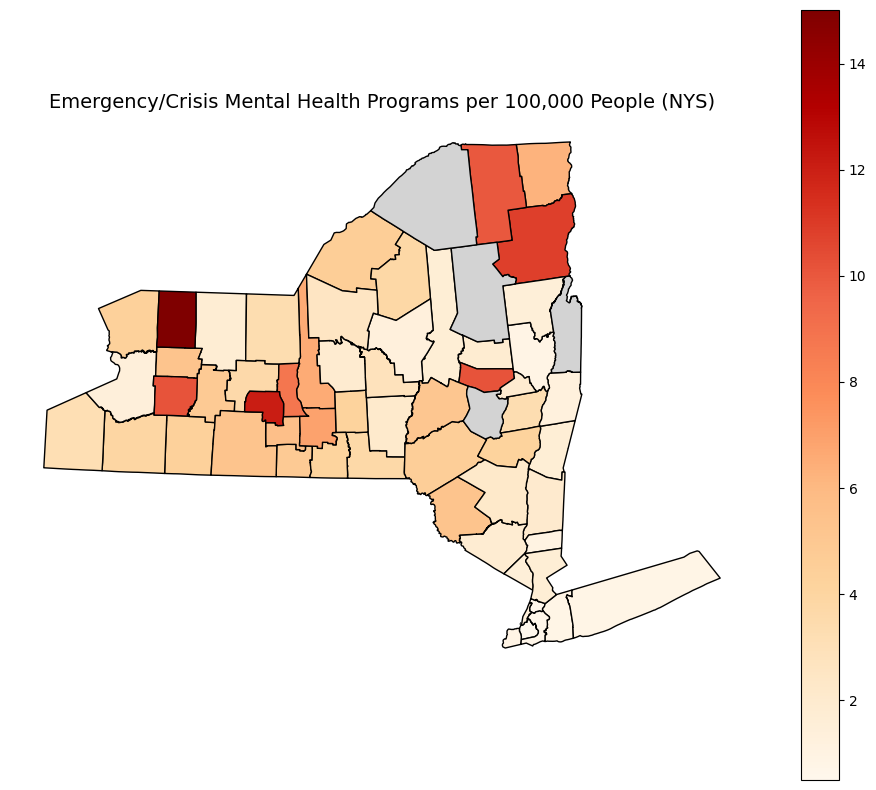

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load shapefile
counties_gdf = gpd.read_file("/content/Counties.shp")
counties_gdf['County'] = counties_gdf['NAME'].str.strip().str.title()

# Merge
counties_merged = counties_gdf.merge(merged_df, on='County', how='left')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
counties_merged.plot(
    column='ProgramsPer100k',
    cmap='OrRd',
    edgecolor='black',
    legend=True,
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "No Data"
    }
)
ax.set_title("Emergency/Crisis Mental Health Programs per 100,000 People (NYS)", fontsize=14)
ax.axis('off')
plt.show()

## Identify Low and High Population Areas with Relative Low Program Density



Building off my finding from the previous section reagrding low program density in high population areas, I identified which high population density (above average) counties demonstrated the lowest (below average) program density and which low population density (below average) counties demonsrated the lowest (below average) program density. I was surprised by just how many counties fell below average population density and program density, but realized that NYC may skew the density average. Likewise, I wonder if program density averages were skewed by few low population density, high program density counties.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute statewide averages
avg_pop_density = pop_df['2020 Population Density'].mean()
avg_program_density = merged_df['ProgramsPer100k'].mean()

# Clean population density
pop_density_df = pop_df[['County', '2020 Population Density']].copy()
pop_density_df.columns = ['County', 'PopDensity']

# Merge population density with program data
merged_with_density = pd.merge(merged_df, pop_density_df, on='County', how='left')

# Filter for counties with above-average population density but below-average program density
underserved = merged_with_density[
    (merged_with_density['PopDensity'] > avg_pop_density) &
    (merged_with_density['ProgramsPer100k'] < avg_program_density)
]

# Sort in ascending order by program density
underserved_sorted = underserved.sort_values(by='ProgramsPer100k', ascending=True)

# Print results
print("Underserved High-Density Counties")
print(underserved_sorted[['County', 'PopDensity', 'ProgramsPer100k']])

Underserved High-Density Counties (Sorted by Program Density)
      County  PopDensity  ProgramsPer100k
14     Bronx    33224.46         0.499592
3      Kings    36596.19         0.551413
2     Queens    20472.21         0.673909
7     Nassau     4749.15         0.814010
29  Richmond     8263.25         0.841526
0   New York    71150.64         1.364774


In [ ]:
# Compute statewide population and program density averages
avg_pop_density = pop_df['2020 Population Density'].mean()
avg_program_density = merged_df['ProgramsPer100k'].mean()

# Clean population density
pop_density_df = pop_df[['County', '2020 Population Density']].copy()
pop_density_df.columns = ['County', 'PopDensity']

# Merge population density with program data
merged_with_density = pd.merge(merged_df, pop_density_df, on='County', how='left')

# Filter for below-average population density AND below-average program density
low_pop_low_access = merged_with_density[
    (merged_with_density['PopDensity'] < avg_pop_density) &
    (merged_with_density['ProgramsPer100k'] < avg_program_density)
]

# Sort in ascending order by program density
low_pop_low_access_sorted = low_pop_low_access.sort_values(by='ProgramsPer100k', ascending=True)

# Print results
print("Underserved Low-Density Counties")
print(low_pop_low_access_sorted[['County', 'PopDensity', 'ProgramsPer100k']])

Underserved Low-Density Counties
         County  PopDensity  ProgramsPer100k
6       Suffolk     1617.99         0.813961
43     Saratoga      284.32         0.868440
51       Putnam      428.02         1.014899
50   Rensselaer      242.33         1.264958
41       Oneida      187.53         1.319575
5          Erie      879.65         1.417294
18     Rockland     1880.87         1.532684
53       Warren       73.52         1.568480
52     Herkimer       43.18         1.640824
1   Westchester     2242.28         1.656654
57     Columbia       93.80         1.679712
4        Monroe     1127.80         1.754623
11       Orange      474.24         1.817077
56       Fulton      106.59         1.893509
35  Schenectady      759.40         1.931024
9      Onondaga      589.95         1.959871
15     Dutchess      368.62         2.045736
55     Chenango       52.29         2.139953
32       Ulster      158.08         2.250782
37       Oswego      122.26         2.578516
48      Madison      1